# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn')
%matplotlib inline

C:\Users\wammi\AppData\Local\Temp\ipykernel_36288\3702442187.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## load_data()

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.stats import zscore

# Loading data function
def load_data(data_dir='data/raw'):
    all_data = []

    for subject in os.listdir(data_dir):
        subject_path = os.path.join(data_dir, subject)
        if not os.path.isdir(subject_path):
            continue

        for session in ['Midterm 1', 'Midterm 2', 'Final']:
            session_path = os.path.join(subject_path, session)
            if not os.path.exists(session_path):
                continue

            try:
                # Load heart rate data
                with open(os.path.join(session_path, 'HR.csv'), 'r') as f:
                    hr_start = float(f.readline())
                    hr_freq = float(f.readline())
                    hr_vals = [float(line.strip()) for line in f]
                    hr_time = [hr_start + i / hr_freq for i in range(len(hr_vals))]
                    df_hr = pd.DataFrame({'timestamp': hr_time, 'heart_rate': hr_vals})

                # Load EDA data
                with open(os.path.join(session_path, 'EDA.csv'), 'r') as f:
                    eda_start = float(f.readline())
                    eda_freq = float(f.readline())
                    eda_vals = [float(line.strip()) for line in f]
                    eda_time = [eda_start + i / eda_freq for i in range(len(eda_vals))]
                    df_eda = pd.DataFrame({'timestamp': eda_time, 'eda': eda_vals})

                # Load temperature data
                with open(os.path.join(session_path, 'TEMP.csv'), 'r') as f:
                    temp_start = float(f.readline())
                    temp_freq = float(f.readline())
                    temp_vals = [float(line.strip()) for line in f]
                    temp_time = [temp_start + i / temp_freq for i in range(len(temp_vals))]
                    df_temp = pd.DataFrame({'timestamp': temp_time, 'temperature': temp_vals})

                # Merge all dataframes on timestamp
                df = df_hr.merge(df_eda, on='timestamp', how='outer')
                df = df.merge(df_temp, on='timestamp', how='outer')
                df['subject_id'] = subject  # Make sure the subject_id is added
                df['session'] = session
                all_data.append(df)

            except FileNotFoundError:
                print(f"Missing file(s) in {session_path}, skipping...")

    # Concatenate all dataframes
    df_all = pd.concat(all_data, ignore_index=True)
    return df_all


## preprocess_data()

In [4]:
def preprocess_data(data, output_dir='data/processed'):
    os.makedirs(output_dir, exist_ok=True)
    processed_data = []

    for subject_id in data['subject_id'].unique():
        subject_df = data[data['subject_id'] == subject_id].copy()
        subject_df['timestamp'] = pd.to_datetime(subject_df['timestamp'], unit='s')
        subject_df.set_index('timestamp', inplace=True)

        # Ensure subject_id is part of the index before resampling
        subject_df['subject_id'] = subject_id

        # Resample data to 1-second intervals and interpolate
        resampled = subject_df.groupby('session').resample('1S').mean().interpolate(method='linear')
        resampled.reset_index(inplace=True)

        # After resampling, make sure subject_id is retained
        resampled['subject_id'] = subject_id

        # Check for missing values
        if resampled.isna().mean().max() > 0.01:
            print(f"Too many missing values for subject {subject_id}, skipping...")
            continue

        # Fill any remaining missing values
        resampled.fillna(method='ffill', inplace=True)
        resampled.fillna(method='bfill', inplace=True)

        # Remove outliers using Z-score
        for col in ['heart_rate', 'eda', 'temperature']:
            if col in resampled.columns:
                z = zscore(resampled[col].fillna(0))
                resampled = resampled[np.abs(z) <= 3.5]

        # Append the processed data
        processed_data.append(resampled)
        resampled.to_csv(os.path.join(output_dir, f'{subject_id}_processed.csv'), index=False)

    final_df = pd.concat(processed_data, ignore_index=True)
    return final_df

## plot_physiological_signals()

In [5]:
# Plotting function
import matplotlib.pyplot as plt

def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    os.makedirs(output_dir, exist_ok=True)

    # Filter data for specified subject and session
    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)].copy()

    if subset.empty:
        raise ValueError(f"No data found for subject {subject_id} and session {session}.")

    # Ensure timestamps are in datetime format
    if not np.issubdtype(subset['timestamp'].dtype, np.datetime64):
        subset['timestamp'] = pd.to_datetime(subset['timestamp'])

    # Create figure with subplots
    fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    axs[0].plot(subset['timestamp'], subset['heart_rate'], color='purple')
    axs[0].set_ylabel('Heart Rate (bpm)')
    axs[0].set_title(f'Subject {subject_id} - {session}')

    axs[1].plot(subset['timestamp'], subset['eda'], color='aqua')
    axs[1].set_ylabel('EDA (µS)')

    axs[2].plot(subset['timestamp'], subset['temperature'], color='magenta')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].set_xlabel('Time')

    plt.tight_layout()
    filename = f"S{subject_id}_{session.replace(' ', '_')}_signals.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath)

    return fig

## test functions

C:\Users\wammi\AppData\Local\Temp\ipykernel_36288\1417552408.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled = subject_df.groupby('session').resample('1S').mean().interpolate(method='linear')
C:\Users\wammi\AppData\Local\Temp\ipykernel_36288\1417552408.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled = subject_df.groupby('session').resample('1S').mean().interpolate(method='linear')
C:\Users\wammi\AppData\Local\Temp\ipykernel_36288\1417552408.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will defa

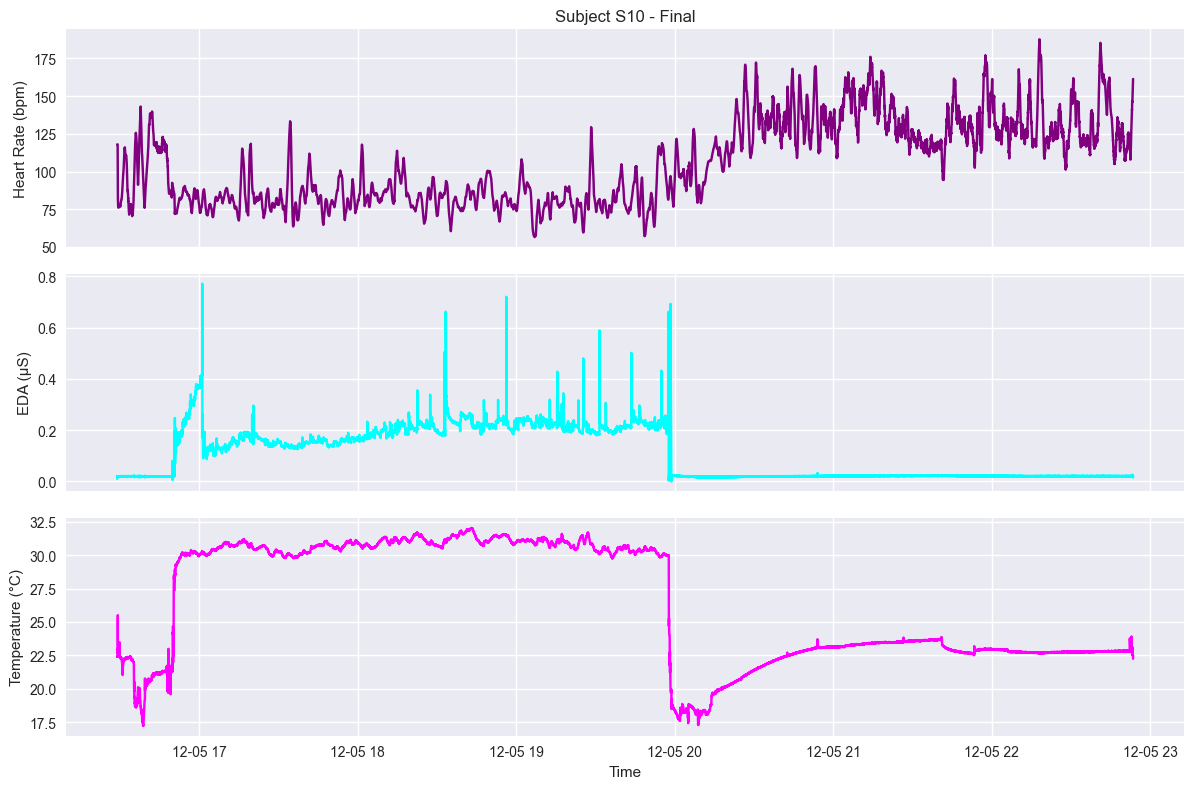

In [7]:
raw_data = load_data('data/')

processed_data = preprocess_data(raw_data, output_dir='data/processed')

fig = plot_physiological_signals(processed_data, subject_id='S10', session='Final', output_dir='plots')